## Metrics and evaluation - Bank Marketing Dataset

In this exercise you will create a classification model to predict whether a client will subscribe to a term deposit or not. You will evaluate the model using different metrics and techniques.

The dataset is hosted in [Kaggle](https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset), although originally published by [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing)
You can also download it manually and update the `path` variable to the appropriate directory in your local environment.

Run the following cell to download the dataset using `kagglehub` package.

In [1]:
pip -q install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub
import pandas

# Download latest version
path = kagglehub.dataset_download("janiobachmann/bank-marketing-dataset")

print("Path to dataset files:", path)

c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Hiram\.cache\kagglehub\datasets\janiobachmann\bank-marketing-dataset\versions\1


In [3]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

In [4]:
# The `path` variable points to the directory of the downloaded files.
# We are interested in the `bank.csv` file specifically.
filepath = Path(path) / Path("bank.csv")

data = pd.read_csv(filepath)

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## EDA

Let's start by exploring the dataset and understanding the features and target variable.
Here is the list of all features in the dataset:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


Additionally, the description of the database in the UCI repository provides more context on each feature:

| Variable Name | Role | Type | Demographic | Description | Units | Missing Values |
|---------------|------|------|-------------|-------------|-------|----------------|
| age           | Feature | Integer | Age | | | no |
| job           | Feature | Categorical | Occupation | type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown') | | no |
| marital       | Feature | Categorical | Marital Status | marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed) | | no |
| education     | Feature | Categorical | Education Level | (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown') | | no |
| default       | Feature | Binary | | has credit in default? | | no |
| balance       | Feature | Integer | | average yearly balance | euros | no |
| housing       | Feature | Binary | | has housing loan? | | no |
| loan          | Feature | Binary | | has personal loan? | | no |
| contact       | Feature | Categorical | | contact communication type (categorical: 'cellular','telephone') | | yes |
| day           | Feature | Date | | last contact day of the week | | no |
| month         | Feature | Date | | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec') | | no |
| duration      | Feature | Integer | | last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. | | no |
| campaign      | Feature | Integer | | number of contacts performed during this campaign and for this client (numeric, includes last contact) | | no |
| pdays         | Feature | Integer | | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) | | yes |
| previous      | Feature | Integer | | number of contacts performed before this campaign and for this client | | no |
| poutcome      | Feature | Categorical | | outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success') | | yes |
| deposit       | Target | Binary | | has the client subscribed a term deposit? | | |


### Target variable analysis

Our target variable is `deposit`, which indicates whether a client has subscribed to a term deposit or not.

Text(0.5, 1.0, "Distribution of target variable 'deposit'")

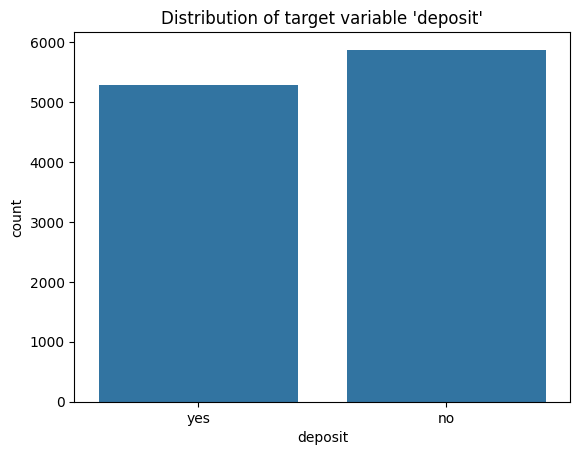

In [6]:
sns.countplot(data=data, x="deposit")
plt.title("Distribution of target variable 'deposit'")

### Feature analysis

Let's start by understanding the descriptive statistics of the dataset.

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


We can also visualize the distribution of numerical features.

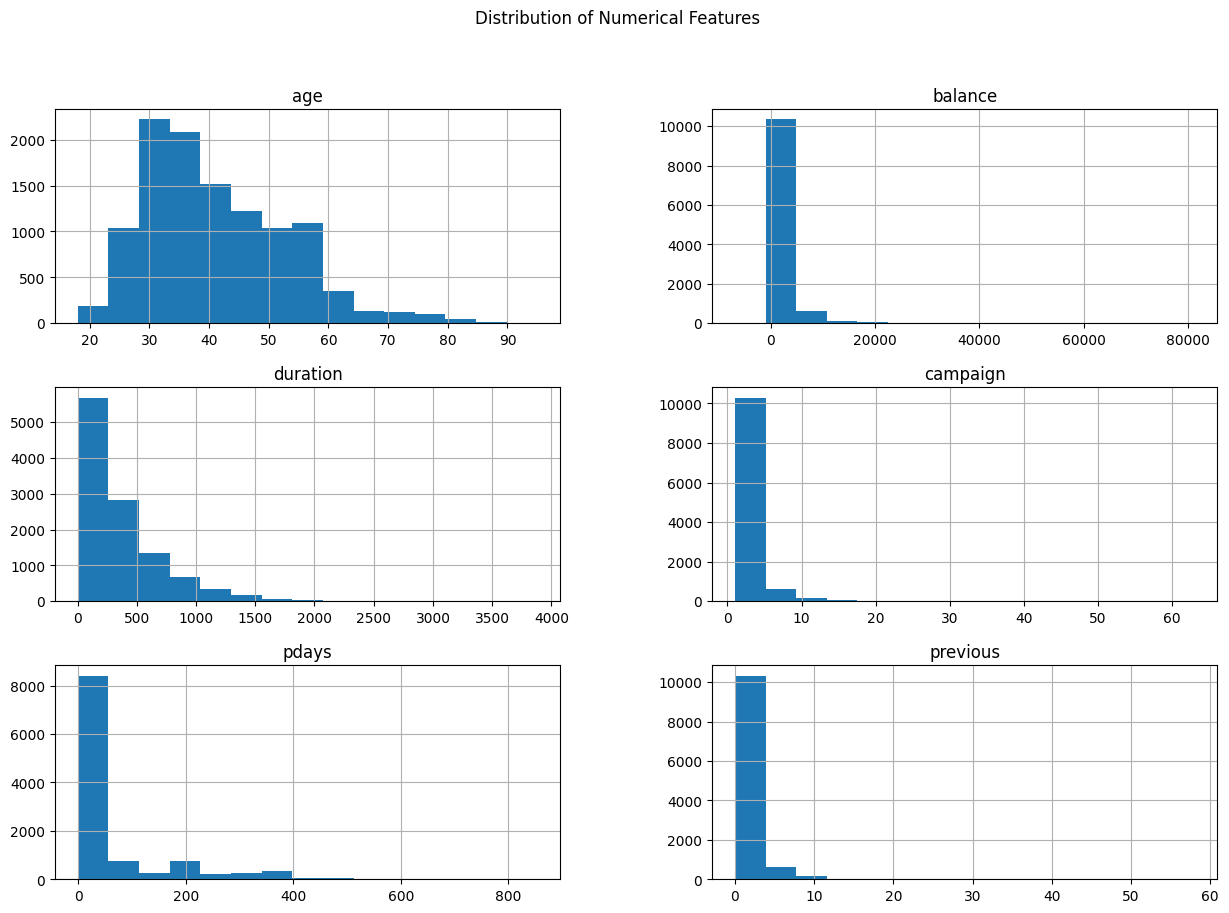

In [8]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous"]

data[numerical_features].hist(bins=15, figsize=(15, 10))
plt.suptitle("Distribution of Numerical Features")
plt.show()

Let's also look at the distribution of categorical features. Note that we are considering day and month as categorical features for this analysis, since they have a limited number of unique values.

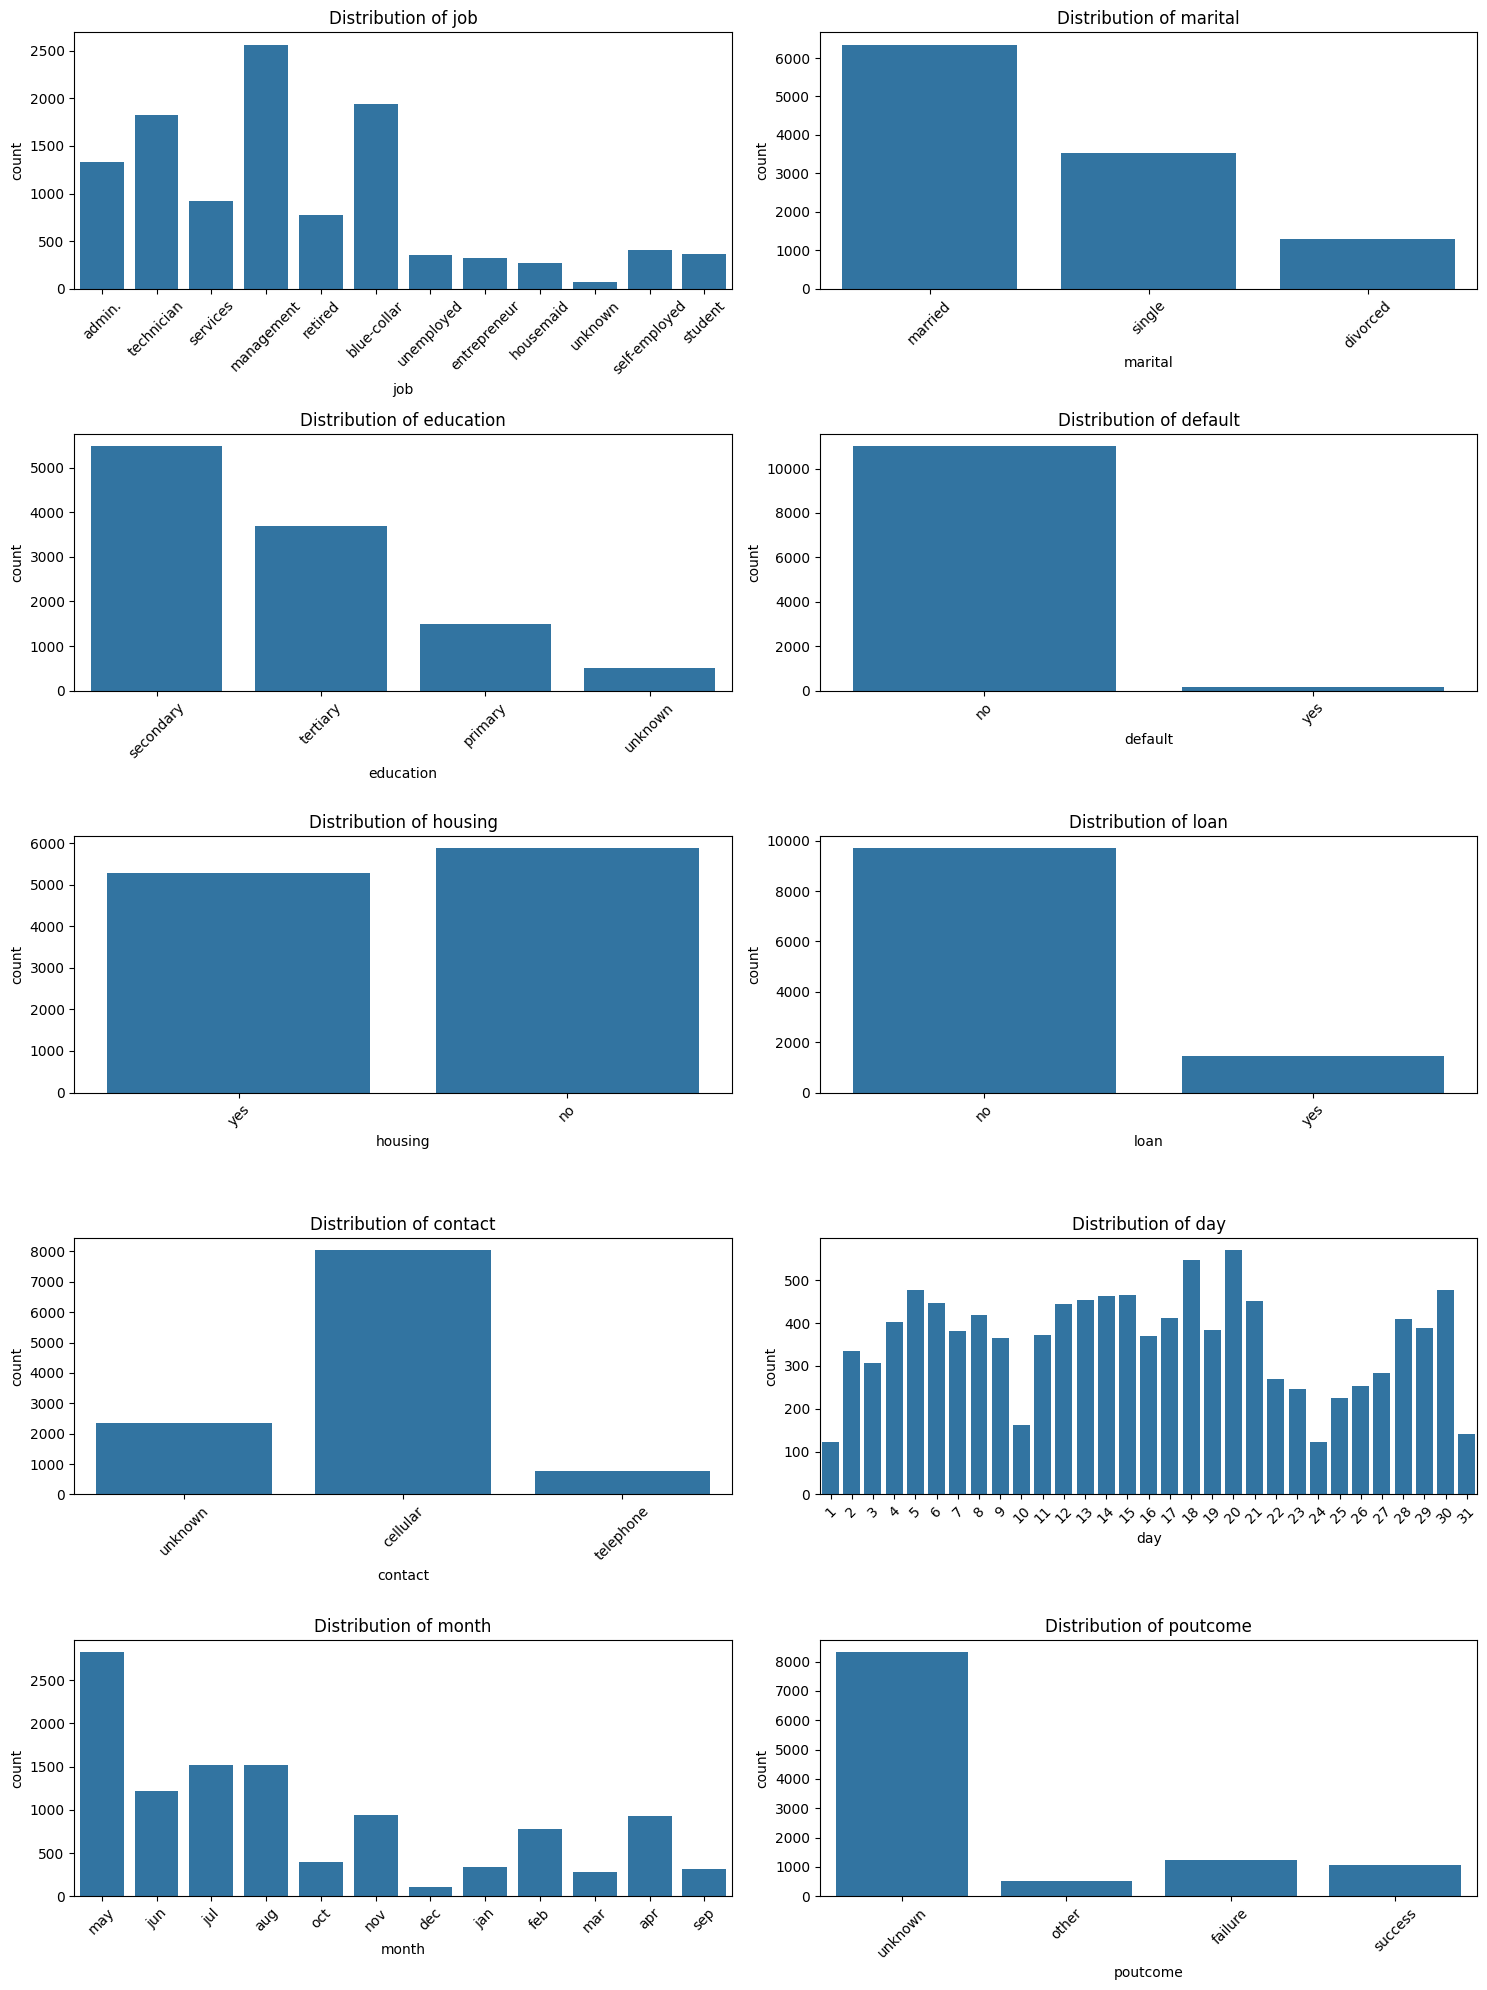

In [9]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "day", "month",
                        "poutcome"]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

We can also explore the proportion of missing values in the dataset. From the description, we know that only `contact`, `pdays`, and `poutcome` have missing values. For `contact` and `poutcome`, 'unknown' is used to denote missing values, while for `pdays`, -1 indicates that the client was not previously contacted. Let's now verify the proportion of these missing values.

Additionally, `job` and `education` also have 'unknown' values, but they are not considered missing values in the dataset description, so we will not include them in this analysis.

In [10]:
missing_contact = (data['contact'] == 'unknown').mean() * 100
missing_pdays = (data['pdays'] == -1).mean() * 100
missing_poutcome = (data['poutcome'] == 'unknown').mean() * 100
missing_job = (data['job'] == 'unknown').mean() * 100
missing_education = (data['education'] == 'unknown').mean() * 100

print(f"Proportion of missing values in 'contact': {missing_contact:.2f}%")
print(f"Proportion of missing values in 'pdays': {missing_pdays:.2f}%")
print(f"Proportion of missing values in 'poutcome': {missing_poutcome:.2f}%")
print(f"Proportion of 'unknown' values in 'job': {missing_job:.2f}%")
print(f"Proportion of 'unknown' values in 'education': {missing_education:.2f}%")

Proportion of missing values in 'contact': 21.02%
Proportion of missing values in 'pdays': 74.57%
Proportion of missing values in 'poutcome': 74.59%
Proportion of 'unknown' values in 'job': 0.63%
Proportion of 'unknown' values in 'education': 4.45%


Let's also explore the relationship between some of the features and the target variable. For numerical features, we can use boxplots to visualize the distribution of the feature values for each class of the target variable.

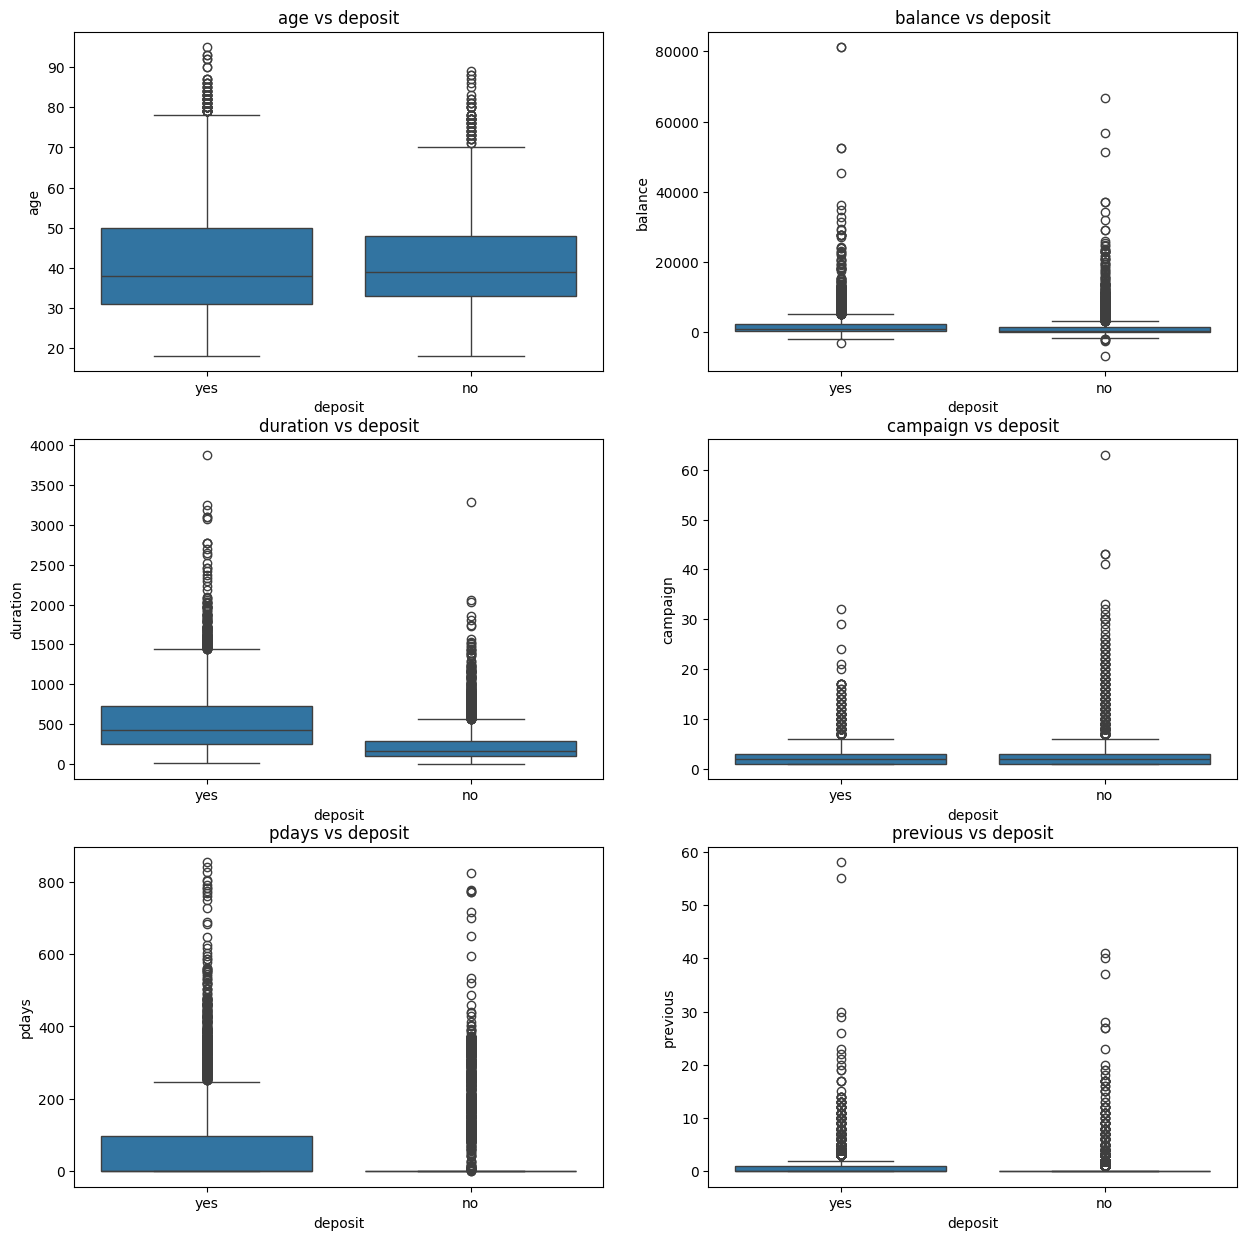

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for ax, feature in zip(axes.ravel(), numerical_features):
    sns.boxplot(data=data, x="deposit", y=feature, ax=ax)
    ax.set_title(f"{feature} vs deposit")

We can also use countplots to visualize the relationship between categorical features and the target variable.

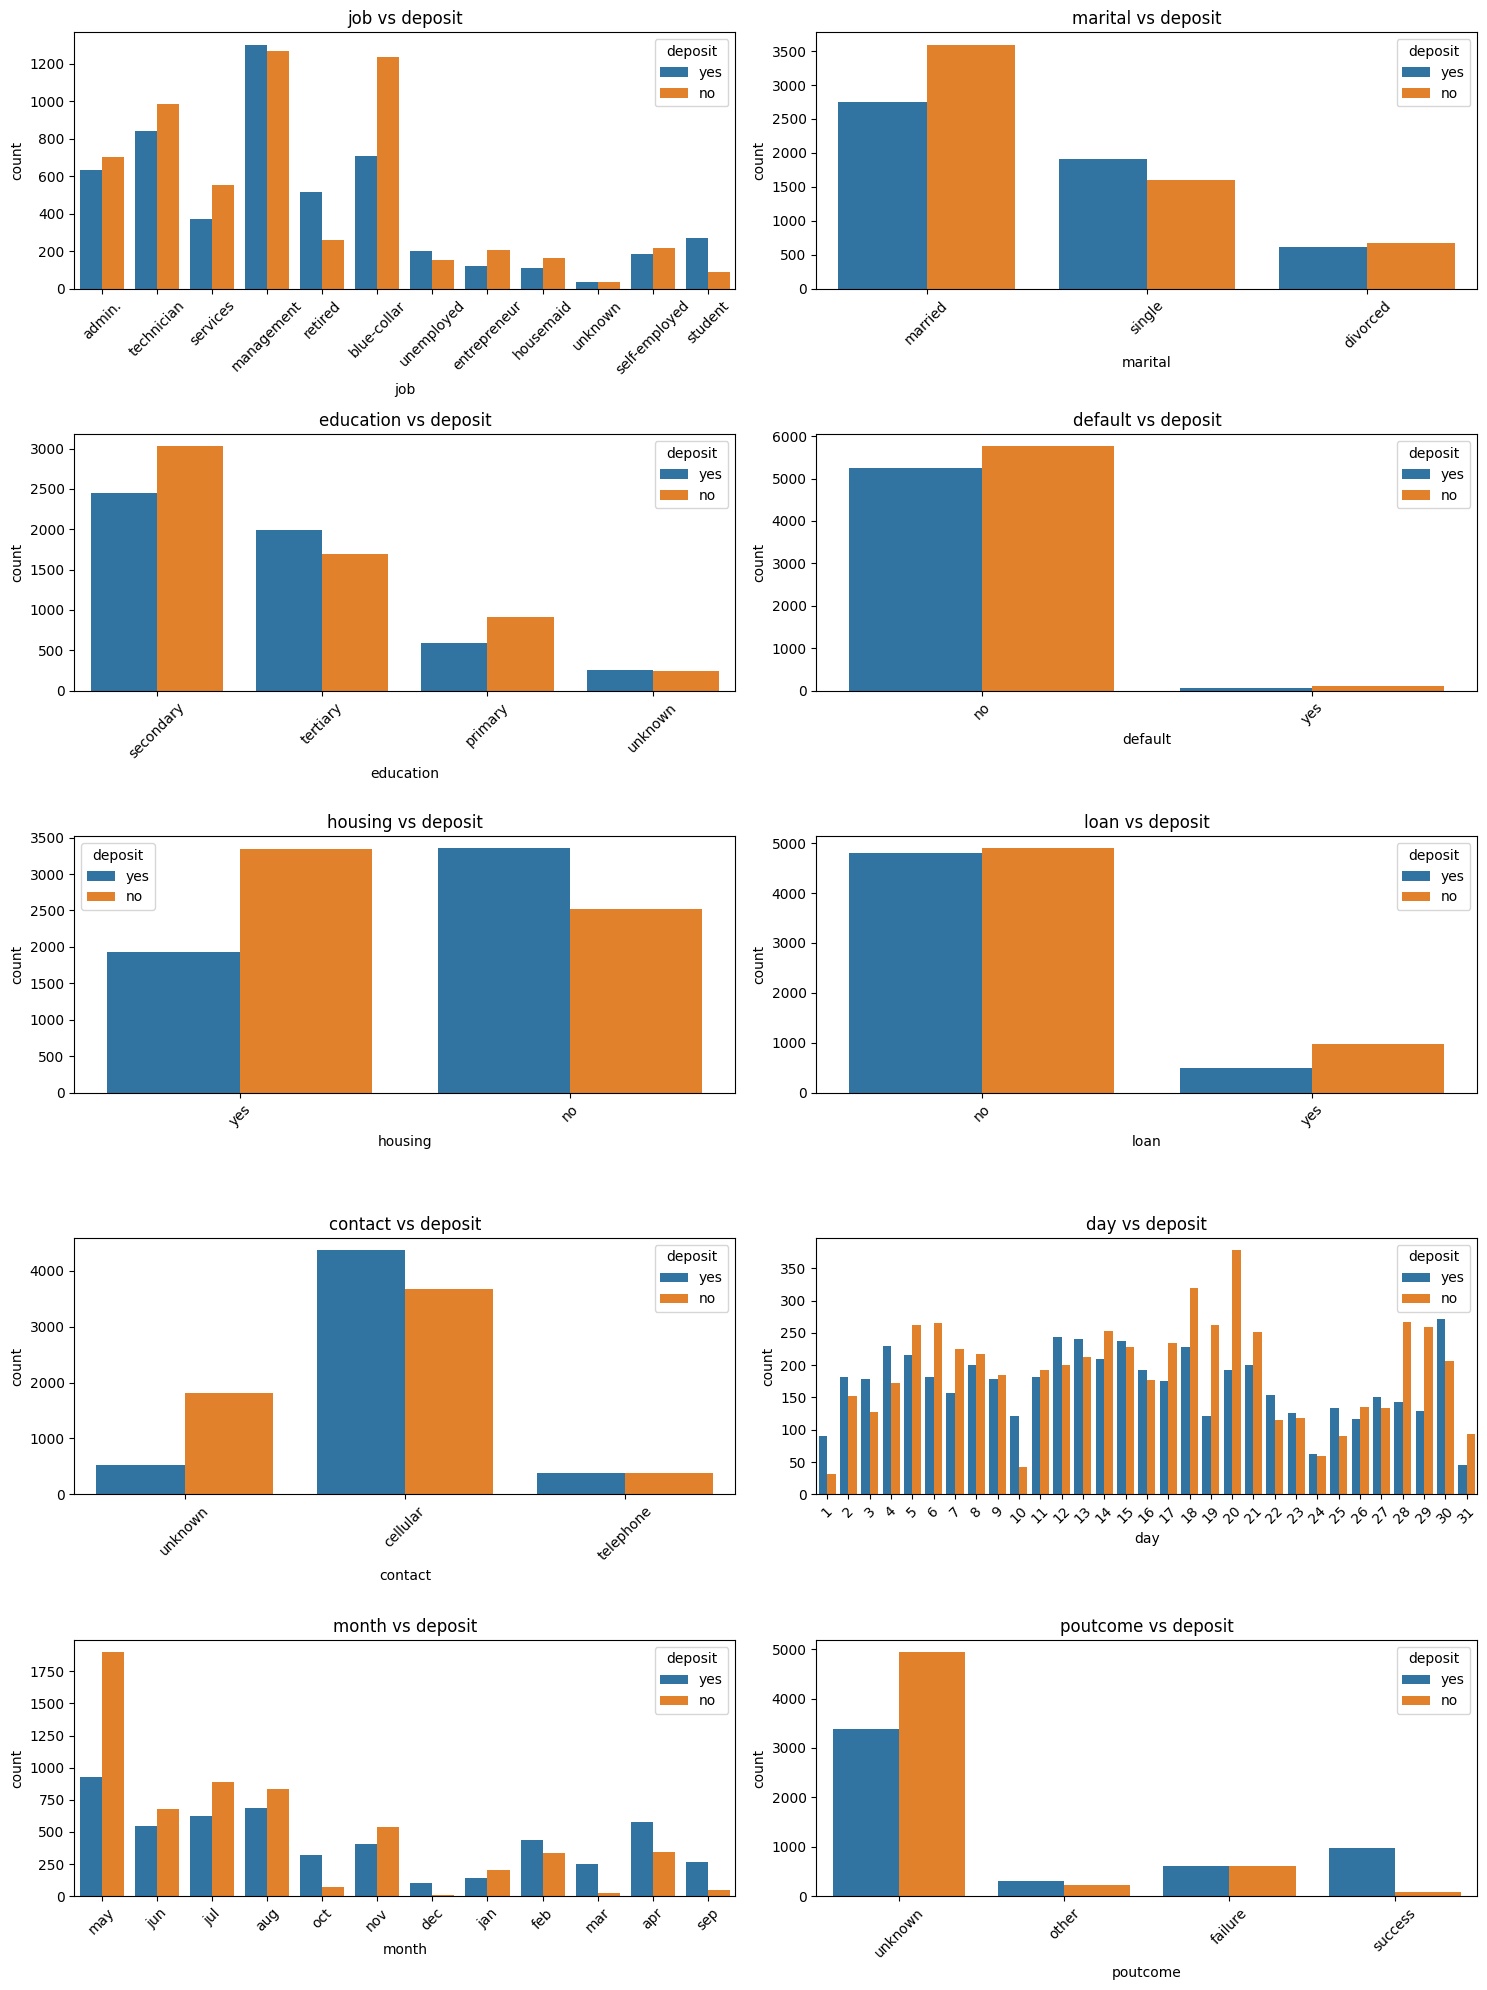

In [12]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

for ax, feature in zip(axes.ravel(), categorical_features):
    sns.countplot(data=data, x=feature, hue="deposit", ax=ax)
    ax.set_title(f"{feature} vs deposit")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

Here we can derive a few insights from the visualizations:
- Clients with existing credits (`housing` and `loan`) are less likely to subscribe to a term deposit.
- Clients who previously subscribed to a term deposit (`poutcome`) are more likely to subscribe again. That said, the majority of clients have not been previously contacted, so this feature may not be very informative for our model.
- The duration of the last contact is much higher for clients who subscribed to a term deposit. However, as mentioned in the dataset description, this feature should be discarded for a realistic predictive model, since it is not known before a call is performed and it highly affects the target variable.
- The distribution of `balance` is also different for the two classes of the target variable, with clients who subscribed to a term deposit having a somewhat higher average balance. However, there are also some outliers in this feature, which may affect the performance of our model.
- Contact method also seems to have an impact on the target variable, with clients contacted via cellular being more likely to subscribe to a term deposit compared to those contacted via telephone. That said, there is also a significant proportion of missing values in this feature, which may affect its usefulness for our model. Also, cellular contact is more common in the dataset, so this feature may be somewhat imbalanced.

## Data preprocessing

Now that we have some understanding of the dataset, we can start with data preprocessing. We will create a pipeline to handle missing values, encode categorical features, and scale numerical features.

The first step is to separate the features and the target variable.

We will drop the `duration` feature as it is not known before a call is performed, and it highly affects the target variable, which would lead to an unrealistic predictive model. We are also dropping `pdays` and `poutcome` due to the high proportion of missing values, which may affect the performance of our model.

In [13]:
x = data.drop(columns=["deposit", "duration", "pdays", "poutcome"])
y = data["deposit"]

Before defining the preprocessing pipeline, we will perform a few simple transformations to the features:
- We will convert the `month` feature to a numerical representation, since it is an ordinal feature with a clear order (January to December).
- We will manually transform any column with `yes` and `no` values to binary 1 and 0, respectively, to simplify the encoding process in our pipeline. This includes our target variable `deposit`, which we will transform to a binary variable as well.
- For `education` and `job` features, we will replace 'unknown' values with the most frequent category in each feature, since 'unknown' is not a meaningful category and it may affect the performance of our model.
- For `education` specifically, we will manually encode the categories (primary, secondary, tertiary) to preserve the ordinal nature of this feature, which may be useful for our model.

Since these transformations are simple and do not require fitting any parameters, we will perform them outside of our preprocessing pipeline for simplicity. However, in a real-world scenario, it would be better to include all transformations in the pipeline to ensure that they are applied consistently to both the training and testing data.

In [14]:
y = y.map({"yes": 1, "no": 0})

x["month"] = x["month"].map({
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
})

binary_columns = ["default", "housing", "loan"]
for col in binary_columns:
    x[col] = x[col].map({"yes": 1, "no": 0})

x["education"] = x["education"].replace("unknown", x["education"].mode()[0])
x["job"] = x["job"].replace("unknown", x["job"].mode()[0])

x["education"] = x["education"].map({
    'primary': 1,
    'secondary': 2,
    'tertiary': 3,
})

We can now split the dataset into training and testing sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Now, let's define our preprocessing pipeline. For numerical features, we will impute missing values with the median and apply a power transformation to reduce skewness. For categorical features, we will impute missing values with the most frequent category and apply one-hot encoding. We will also set `remainder="passthrough"` in the `ColumnTransformer` to ensure that any columns not specified in the transformers are passed through without transformation (in this case, there should not be any, but it's a good practice to include this parameter). Additionally, we will set `verbose_feature_names_out=False` to get more readable feature names after transformation.

In [16]:
preprocessing = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("num", make_pipeline(SimpleImputer(strategy="median"), PowerTransformer()),
             ["age", "balance", "campaign", "previous"]),
            ("cat", make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore")),
             ["marital", "contact", "job"])
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
)

Let's transform the training data using our preprocessing pipeline and take a look at the transformed features. Note that the output of the `ColumnTransformer` will be a NumPy array, so we will convert it back to a DataFrame for better readability, using the feature names generated by the transformers.

In [17]:
X_train = preprocessing.fit_transform(X_train)
feature_names = preprocessing.named_steps["columntransformer"].get_feature_names_out()
X_train = pd.DataFrame(X_train, columns=feature_names)
X_train.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,-1.288254,1.440574,1.434931,1.830018,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,10.0,9.0
1,-0.526827,-0.307910,0.878943,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,21.0,8.0
2,0.715215,-0.381555,-1.041703,1.500969,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,10.0,11.0
3,1.047190,0.299080,-1.041703,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,15.0,12.0
4,1.047190,0.183543,0.878943,1.882117,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,11.0,11.0


Let's repeat the same transformation for the testing data. Note that we will use `transform` instead of `fit_transform` to ensure that the same transformations are applied to the testing data as were learned from the training data.

In [18]:
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_test.head()

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
0,1.697695,-0.142732,-1.041703,-0.577272,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,7.0
1,-0.111115,0.184589,1.833573,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,16.0,6.0
2,-0.417067,1.220943,-1.041703,1.500969,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,14.0,5.0
3,0.643284,2.111136,0.275043,-0.577272,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,8.0,8.0
4,-0.417067,0.130425,0.878943,-0.577272,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,12.0,5.0


## Model training and evaluation

Instructions: Complete this exercise by training a classification model on the preprocessed training data and evaluating its performance on the testing data using appropriate metrics such as accuracy, precision, recall, and F1-score.

Try with at least 3 different classification algorithms (e.g., Logistic Regression, Random Forest, Support Vector Machine) and compare their performance. For each of them, use GridSearchCV to find the best hyperparameters and report the results.

Lastly, compare the performance of the models and, for the best one (based on your chosen evaluation metric), display a confusion matrix and a classification report to analyze the results in more detail. 

### Defining objective metrics

**HIRAM METRICAS**

Okay las metricas que yo defenderia fuera recall, porque el problema menciona que se quiere maximizar el retorno de inversion (ROI), entonces el recall donde define como una buena metrica cuando el costo de los falsos negativos es alto, seria un buen fit aqui, porque nosotros preferimos marcar a gente que no acepte la plaza, PERO, no queremos saltarnos gente que potencialmente pudiera comprarnos la plaza, porque con perder 1 persona que si hubiera comprado la plaza se baja el ROI, recall es una buena metrica, pero el problema tambien dice que se quiere reducir el contacto necesario y se mejora la experiencia al cliente, entonces no solo necesitamos maximizar falsos positivos de manera arbitraria, necesitamos encontrar un balance para poder seguir teniendo una buena experiencia al cliente.

**Yo propongo** usar F1, ya que es un balance entre recall y precision, si queremos penalizar los falsos negativos, pero tambien queremos un balance y no llamar a todos de manera indiscriminada para mantener una buena atencion al cliente, adicionalmente al F1, me apoyaria de la matriz de confusion, ya que al estar buscando un balance, igualmente no me gustaria que la cantidad de falsos negativos sea muy alta o sea mayor a los falsos positivos entonces **usaria F1 y me apoyaria con la matriz de confusion** para verificar lo que esta pasando. A parte F1 es buena opcion porque las clases output estan balanceadas y accuracy se beneficia de esto.

In [19]:
pip -q install xgboost

Note: you may need to restart the kernel to use updated packages.


### Training and evaluating different models

In [20]:
from collections import Counter
 
Counter(y_train)

Counter({0: 4707, 1: 4222})

In [21]:
X_train.describe().loc[["count"]]

,age,balance,campaign,previous,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,...,job_services,job_student,job_technician,job_unemployed,education,default,housing,loan,day,month
count,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,...,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0,8929.0


Tenemos casi 9000 registers entonces podemos usar modelos mas robustos para que se beneficien de tantos datos

#### Model 1 - [**XGBoost**]

Propongo XGBoost porque esta a base de arboles y hace overfit facil pero en este momento tenemos buena cantidad de datos y vale la pena probarlo si hacemos el cross-validation de manera correcta


In [22]:
import xgboost as xgb
print(xgb.__version__)

3.1.3


In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Cross validation con 5 folds como marca la actividad, estratificados para que siga balanceado durante folds

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    device="cuda",
    random_state=42
)
    
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [300, 600],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}


gs = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="f1",   # Definimos la metrica a optimizar, f1 , ya despues podremos plotear el corr heatmap
    cv=cv,
    n_jobs=-1,
    refit=True
)

gs.fit(X_train, y_train)
best_model = gs.best_estimator_

print("XGBoost device:", best_model.get_params().get("device"))  # Solo para quitarme la espinita de si use CUDA o no jaja

XGBoost device: cuda


In [28]:
print(best_model.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 600, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


#### Model 2 - [**HistGradientBoost**]

Este tambien es otro metodo de arboles pero creo que podemos tener buenas metricas con este tipo de metodos

In [24]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds

hgb = HistGradientBoostingClassifier(
    random_state=42
)

param_grid_hgb = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [None, 3, 5, 8],
    "max_leaf_nodes": [15, 31, 63],
    "min_samples_leaf": [10, 20, 50],
    "l2_regularization": [0.0, 0.1, 1.0],
    "max_bins": [255],  
}

gs_hgb = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid_hgb,
    scoring="f1", #misma metrica para los 3
    cv=cv,
    n_jobs=-1,
    refit=True
)

gs_hgb.fit(X_train, y_train)

print("HGB best params:", gs_hgb.best_params_)
print("HGB best CV F1:", gs_hgb.best_score_)

best_hgb = gs_hgb.best_estimator_





GridSearchCV

HGB best params: {'l2_regularization': 1.0, 'learning_rate': 0.05, 'max_bins': 255, 'max_depth': None, 'max_leaf_nodes': 63, 'min_samples_leaf': 20}
HGB best CV F1: 0.6929959241157697


sklearn.model_selection._search.GridSearchCV

#### Model 3 - [**SVC**]

Este si no es de arboles pero creo que si identificamos si tenemos features con relacion lineal o no podemos beneficiarnos de su kernel, entonces primero correre unas funciones para ver que queda mejor y ya despues decido si probar SVC Linear o con RBF

In [25]:
# Primero vamos a usar MI para ver las features con el outcome, MI puede decirme bien si hay relacion con el target pero de manera no linear
# a veces captura relaciones no lineares: 
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train, y_train, random_state=42)
mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
print(mi_scores)

top4 = mi_scores.head(4).index.tolist()
print("Top-4 por MI:", top4)


month                0.047428
balance              0.040026
contact_unknown      0.036195
age                  0.026682
contact_cellular     0.026195
previous             0.025066
housing              0.021071
day                  0.018881
education            0.016345
marital_married      0.014357
job_admin.           0.008547
marital_single       0.008329
job_management       0.006890
job_retired          0.006583
campaign             0.006457
default              0.005629
loan                 0.004962
job_housemaid        0.004898
job_unemployed       0.003546
marital_divorced     0.003519
job_blue-collar      0.003379
job_self-employed    0.001494
job_student          0.000066
contact_telephone    0.000000
job_entrepreneur     0.000000
job_services         0.000000
job_technician       0.000000
dtype: float64
Top-4 por MI: ['month', 'balance', 'contact_unknown', 'age']


In [26]:
# Corr para ver correlacion muchas veces Linear

train_df = X_train.copy()
train_df["Outcome"] = y_train.values

corr_scores = train_df.corr(numeric_only=True)["Outcome"].sort_values(ascending=False)
print(corr_scores)


Outcome              1.000000
previous             0.232079
contact_cellular     0.226287
education            0.106990
balance              0.100319
job_retired          0.095277
job_student          0.089635
marital_single       0.085728
job_management       0.041275
month                0.029009
job_unemployed       0.021368
contact_telephone    0.010745
marital_divorced     0.005130
job_admin.           0.005038
job_self-employed   -0.004016
job_technician      -0.004813
age                 -0.008418
job_housemaid       -0.025075
job_entrepreneur    -0.037790
default             -0.038681
job_services        -0.046655
day                 -0.051525
marital_married     -0.083814
job_blue-collar     -0.099022
loan                -0.109854
campaign            -0.127984
housing             -0.194485
contact_unknown     -0.256071
Name: Outcome, dtype: float64


Gracias al MI y a corr, como son diferentes podemos ver que si hay relaciones no lineales entonces voy a usar SVC RBF, tambien tenemos muchisimas features jajaa entonces puede beneficiarse de eso tambien

In [27]:
from sklearn.svm import SVC

# Iba a usar scaler para el SVC pero usted ya uso antes con powertransformer entonces me lo salto jaaj

svc_rbf = SVC(kernel="rbf") # Kernel por las relaciones no lineales, vamos a probar



param_grid_svc = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", 0.01, 0.1, 1],
}

gs_svc = GridSearchCV(
    estimator=svc_rbf,
    param_grid=param_grid_svc,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True
)

gs_svc.fit(X_train, y_train)

print("SVC RBF best params:", gs_svc.best_params_)
print("SVC RBF best CV F1:", gs_svc.best_score_)

best_svc = gs_svc.best_estimator_

SVC RBF best params: {'C': 1, 'gamma': 0.1}
SVC RBF best CV F1: 0.6737164430491738


### Comparing model performance

Vamos a correr los modelos en el hold-out test una sola vez para ver como se comportan y elegir el mejor modelo

In [29]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Funcion para evaluar en nuestro hold-out test SOLO hasta el final
def eval_holdout(model, X_test, y_test, name="model"):
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name} - Holdout F1: {f1:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return f1

# Definimos los modelos que le vamos a pasar a la funcion del best estimator que dio el grid search porque le pusimos refit true entonces 
# No tenemos que volver a entrenar o algo por el estilo solo lo llamamos
best_svc = gs_svc.best_estimator_ # SVC
best_hgb = gs_hgb.best_estimator_ # HistBoost
best_xgb = gs.best_estimator_    #XGBoost


In [30]:
eval_holdout(best_svc, X_test, y_test, "SVC RBF")


SVC RBF - Holdout F1: 0.6865
Confusion matrix:
 [[999 167]
 [422 645]]
              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1166
           1       0.79      0.60      0.69      1067

    accuracy                           0.74      2233
   macro avg       0.75      0.73      0.73      2233
weighted avg       0.75      0.74      0.73      2233



0.6865353911655135

In [31]:
eval_holdout(best_hgb, X_test, y_test, "HistGradientBoost")


HistGradientBoost - Holdout F1: 0.6991
Confusion matrix:
 [[977 189]
 [392 675]]
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1166
           1       0.78      0.63      0.70      1067

    accuracy                           0.74      2233
   macro avg       0.75      0.74      0.73      2233
weighted avg       0.75      0.74      0.74      2233



0.6991196271361989

In [32]:
eval_holdout(best_xgb, X_test, y_test, "XGBoost")

c:\Users\Hiram\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:774: UserWarning: [15:05:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



XGBoost - Holdout F1: 0.6983
Confusion matrix:
 [[971 195]
 [390 677]]
              precision    recall  f1-score   support

           0       0.71      0.83      0.77      1166
           1       0.78      0.63      0.70      1067

    accuracy                           0.74      2233
   macro avg       0.74      0.73      0.73      2233
weighted avg       0.74      0.74      0.73      2233



0.6982980917998969

### Best model analysis

Los 3 fueron muy similares pero HistGradientBoost fue el mejor, posiblemente si hubieramos hecho mas tuning o algo mas a fondo pudieramos haber mejorado el modelo pero 0.7 casi esta conforme

Hacemos un analisis del ultimo mejor modelo

HistGradientBoost (Holdout)
F1       : 0.6991
Precision: 0.7812
Recall   : 0.6326

Classification report:
              precision    recall  f1-score   support

           0     0.7137    0.8379    0.7708      1166
           1     0.7812    0.6326    0.6991      1067

    accuracy                         0.7398      2233
   macro avg     0.7475    0.7353    0.7350      2233
weighted avg     0.7460    0.7398    0.7366      2233

Confusion matrix:
[[977 189]
 [392 675]]


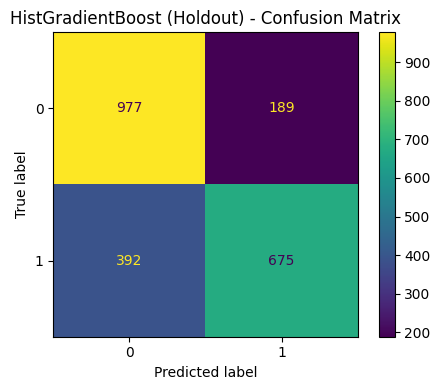

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

def report_y_confmat(model, X_test, y_test, title="HistGradientBoost (Holdout)"):
    # Predicciones
    y_pred = model.predict(X_test)

    # Metricas basicas
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(title)
    print(f"F1       : {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")

    # Reporte completo
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusion (numeros)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:")
    print(cm)

    # Grafica bonita
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, values_format="d")  # "d" = enteros
    ax.set_title(title + " - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {"f1": f1, "precision": prec, "recall": rec, "cm": cm}

# Uso:
# best_hgb = gs_hgb.best_estimator_  (si refit=True)
result_hgb = report_y_confmat(best_hgb, X_test, y_test, title="HistGradientBoost (Holdout)")

"yes": 1 , "no": 0

### Final remarks

Bueno para este proyecto creo que no fue bueno optimizar el F1 de una, creo que mejor hubieramos optimizado recall, porque? intente encontrar un balance y aun asi penalizar mas los falsos negativos, pero aun asi al final al usar la matriz de confusion para ver los resultados podemos ver en la grafica que predecimos mas el 0 cuando era 1 y 1 era que si aceptaban el plazo, el chiste era predecir mas 1 cuando era 0 en realidad y nos equivocamos jaja, creo que tenemos un buen modelo con buen accuracy, pero no es el mejor para lo que nosotros buscabamos, hubieramos optimizado recall mejor. No fue el mejor modelo para lo que buscamos porque cuando tienes una persona que posiblemente si quiera aceptar el plazo hay mas probabilidad de predecir que no lo va a aceptar a la realidad que es que si lo aceptaria.

Creo que en si tenemos un buen modelo porque no alcanzamos a probar los modelos lineales pero creo que les hubieramos ganado y hicimos bien al utilizar modelos basados en arboles o metodos de kernels

Como una ultima conclusion: **Tenemos un modelo con buena precision: 0.78, pero no es el mejor para lo que queremos, nuestro modelo es mejor si prioritamos el servicio al cliente que el ROI porque prefereria predecir que una persona no va a aceptar el plazo a que si lo aceptaria, aunque la realidad fuera que si lo va a aceptar**

**Future work: volver a probar mas parametros y optimizar recall en vez de f1**